In [1]:
# imports
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.table as at
import george # I should really use the avocado 2D Gaussian process directly 
from george import kernels
import glob
from collections import Counter
from scipy.optimize import minimize
import scipy.interpolate as scinterp
import light_curve as lcpy

In [2]:
files = glob.glob('20*dat') # get the list of IIp for Jason's paper
print(files)

['2020jww_FPztf.dat', '2020hgw_FPztf.dat', '2020jfo.dat', '2020rth_FPztf.dat']


In [3]:
data_dict = {}

for file in files:
    # format object name from file
    obj_name = file.replace('.dat','').split('_')[0]
    
    # read the light curve
    lc = at.Table.read(file, names=('mjd', 'mag', 'mag_err', 'pb', 'zpt'), format='ascii.no_header', data_start=2)
    # we're skipping redshift and redshift error, but I should not need this for this analysis

    # toss points with very large mag errors
    ind = (lc['mag_err'] < 0.3)
    lc = lc[ind]

    survey, filt = list(zip(*[x.split('.') for x in lc['pb']])) 
    lc['survey'] = survey
    lc['filt'] = [x.replace('prime_filter','').replace('cyan','c').replace('orange','o') for x in filt]

    data_dict[obj_name] = lc

In [4]:
filt_col_map = {'g':'C2', 'r':'C3', 'i':'C1', 'c':'cyan', 'o':'gold', 'z':'tab:grey', 'w':'black'}
survey_marker_map =  {'PAN-STARRS/PS1':'D', 'Palomar/ZTF':'*', 'Misc/Atlas':'v'}

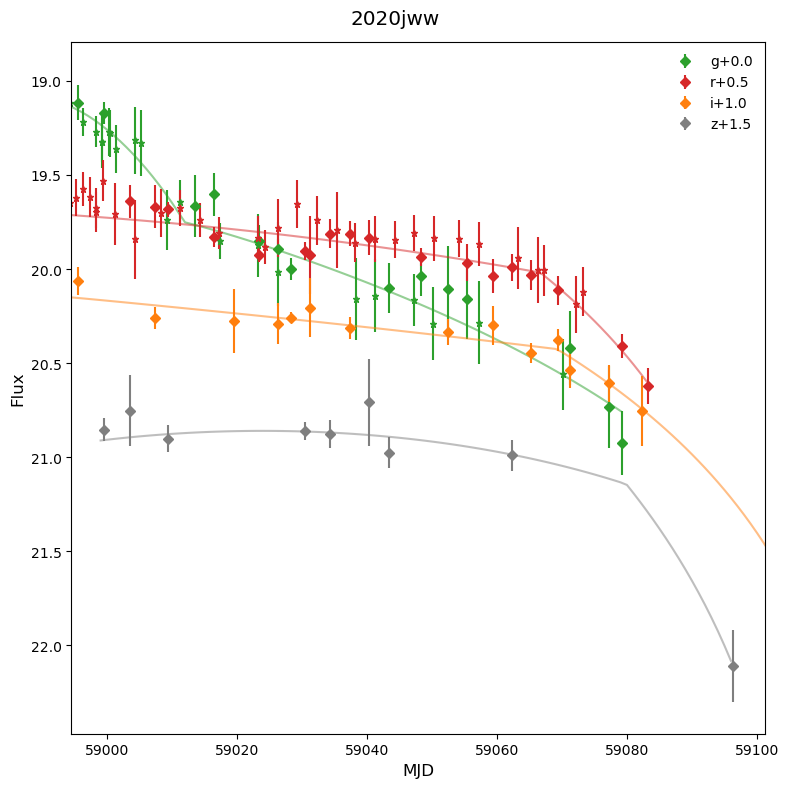

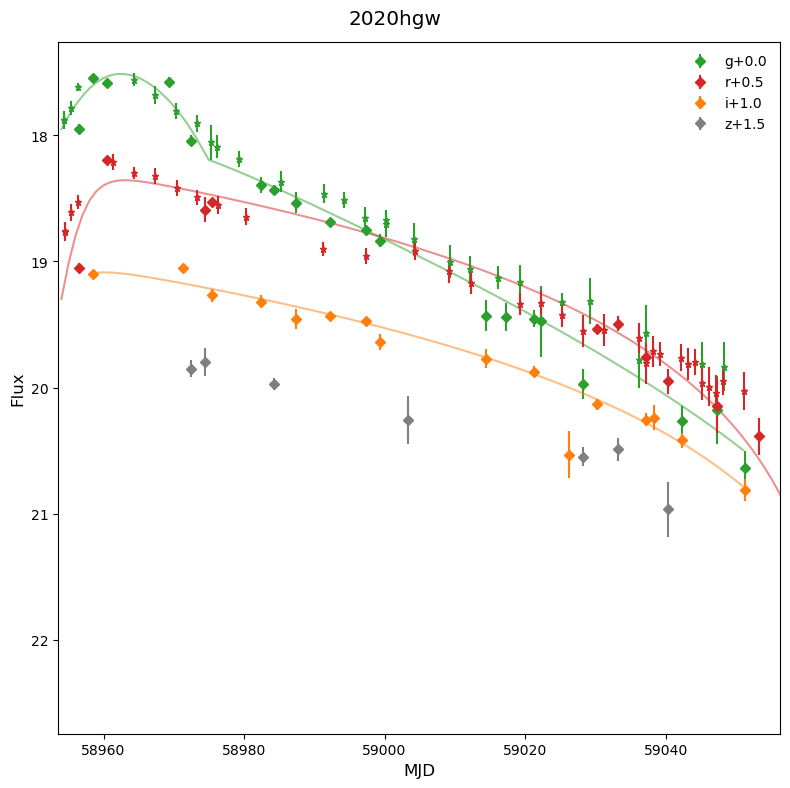

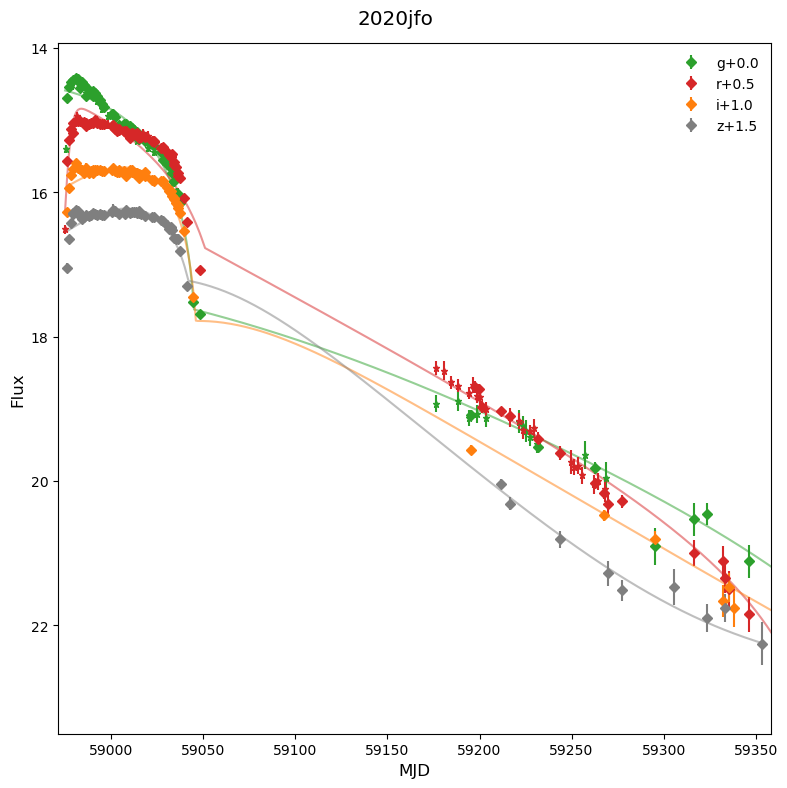

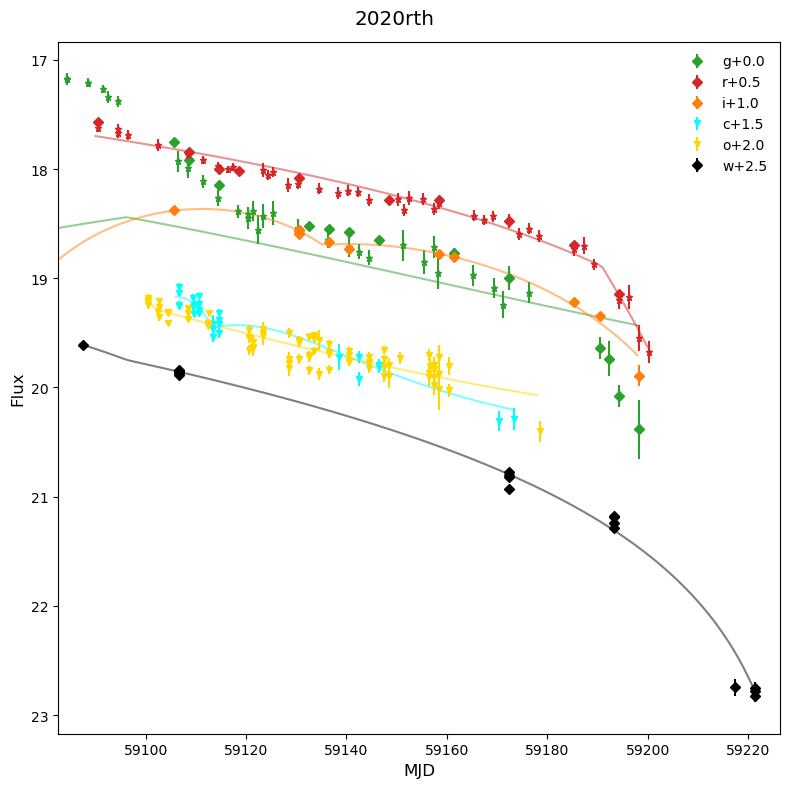

In [5]:
# we need some helper functions for the GP - likelihood (or negative log likelihood) and it's gradient
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)


# loop over all the objects
for obj in data_dict:


    # restore the data for this object 
    lc = data_dict[obj]
    
    # figure out how many observations we have in each passband
    pb_counts = Counter(lc['filt'])

    # create a plot per object
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

    # loop over each passband
    ctr = 0.
    for pb in filt_col_map:

 
        # consider data in just this passband
        this_pb = lc['filt'] == pb
        
        x    = lc['mjd'][this_pb]
        m    = lc['mag'][this_pb]
        merr = lc['mag_err'][this_pb]
        survey = lc['survey'][this_pb]

        cts = pb_counts[pb]

        if cts > 0:
            # give each survey a different marker
            flag = 0
            for s in survey_marker_map:
                label = None # reset the label 
                ind = (survey == s)
                if len(x[ind]) > 0:
                    flag += 1

                    if flag == 1:
                        label=f'{pb}+{ctr:0.1f}'
                    else:
                        label = None

                    # plot the data 
                    ax1.errorbar(x[ind], m[ind] + ctr, yerr=merr[ind],\
                    marker=survey_marker_map[s], linestyle='None', label=label, color=filt_col_map[pb], ms=5)

        # skip fitting if we don't have enough observations
        if cts <= 8:
            continue # need at least these many measurements for the Bazin fit 

        # convert to flux - necessary for VillarFit
        f = 10.**(-0.4*(m-25.))
        ferr = f*(np.log(10.)/2.5)*merr
        
        # I need a very rough guess for the time of maximum 
        # we'll just use the maximum flux 
        peakguess_date = x[f.argmax()]

        # I don't want data too far before or after this 
        ind = (x > peakguess_date - 100.) &  (x < peakguess_date + 500.)

        # rescale the fluxes to be 0-1 
        frange = (f[ind].max() - f[ind].min())
        fmin = f[ind].min()

        # rescaled fluxed = rf - this is just z-scaling - and is perfectly invertible
        rf = (f - fmin)/frange
        rferr = ferr/frange

        # omly fit the data in the time window we want
        x = x[ind]
        m = m[ind]
        merr = merr[ind]
        rf = rf[ind]       
        rferr = rferr[ind]
        survey = survey[ind]

        # setup a time grid
        x_pred = np.arange(np.floor(x.min()), np.ceil(x.max()), 1.) 
        # you can change 1. above to a smaller number if you want higher resolution
        
        # instantiate a Bazin fit for this object in this band
        bazin = lcpy.VillarFit('mcmc', mcmc_niter=20000)
        bazinres = bazin(x, rf, sigma=rferr, sorted=True)

        
        bazinmean = bazin.model(x, bazinres) # values at the location of the data
        bazinpred = bazin.model(x_pred, bazinres) # values on the uniform grid
        predmag = -2.5*np.log10((bazinpred*frange) + fmin) + 25.  # convert back to mags
        
        # plot fit
        ax1.plot(x_pred, predmag + ctr, linestyle='-', color=filt_col_map[pb], alpha=0.5)

        ctr +=0.5 # just add a vertical offset to make the photometry easier to see
        ax1.set_xlim(x.min()-5, x.max()+5)

    ax1.legend(loc='upper right', frameon=False, fontsize='medium')
    ax1.set_xlabel('MJD', fontsize='large')
    ax1.set_ylabel('Flux', fontsize='large')
    ax1.invert_yaxis()
    fig.suptitle(obj, fontsize='x-large')
    fig.tight_layout()
    fig.savefig(f'{obj}_Villar_Fit.pdf')
